# Deep Learning of the Extreme Value Index

Estimating the extreme value index, which describes the tail behavior of Pareto-type distributions, is a complex task and estimators usually depend on the choice of a threshold, above which the data can be used for statistical inference on extreme events.<br> 
More specifically, in extreme value analysis one considers observations from a distribtuion function $F$, which can be approximated by a Pareto distribution in the tail. This means that for $x$ large enough, $$ 1-F(x)\approx x^{-1/\gamma}, $$ for $\gamma>0$. The extreme value index $\gamma$ describes how likely extremely high observations $x$ are. The higher $\gamma$ the more likely are extreme outliers. <br>

The question I want to discuss here is: Can I train a network on random samples to determine the extreme value index without the selection of a threshod?

In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import random

np.random.seed(42)
tf.set_random_seed(42)

In the following the training data is generated and the labels contain the value of the corresponding extreme value index $\gamma$. For the network to learn well it is very important to obtain training samples, which represent a broad class of distributions. <br>
Since I am working on samples from heavy-tailed distributions, which can include extremely high values, I can not use the samples directly for training the network. Instead of the raw obervations I look at their logarithm. This trick leads to a more reasonable range of observed values and is also a natural thing to do in extreme value statistics, as it leads to an exponential approximation of the peak-over-threshold approach instead of a pareto approximation.

In [48]:
N=500  # sample size
M=5000 # number of samples

train_data=np.zeros((3*M,N))
labels=np.zeros(3*M)

# generate M samples following a t-distribution with a random degree of freedom between 1 and 12
for i in range(M):
    degree=np.random.randint(1,12)
    X=np.random.standard_t(df=degree, size=N)
    train_data[i,]=np.log(abs(X))
    labels[i]=1./degree

# generate M samples following a Frechet distribution with random extreme value index between 0 and 3.
for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=stat.invweibull.rvs(c=1/gamma, size=N)
    train_data[M+i,]=np.log(X)
    labels[M+i]=gamma

# generate M samples following a Burr distribution with random extreme value index between 0 and 3.
for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=np.random.uniform(size=N)
    X=np.power((1/(1-X) -1), gamma)
    train_data[2*M+i,]=np.log(X)
    labels[2*M+i]=gamma
    

## The network architecture

In the case considered here, where the input does not contain structral properties, a useful network is a fully connnected sequential model.

In [49]:
modelH=tf.keras.models.Sequential()
modelH.add(tf.keras.layers.Dense(N, input_shape=(N,) , activation='relu', use_bias=True))
modelH.add(tf.keras.layers.Dense(2*N, activation='relu', use_bias=True ))
modelH.add(tf.keras.layers.Dense(N, activation='relu', use_bias=True ))
modelH.add(tf.keras.layers.Dense(1, use_bias=True))

modelH.compile(optimizer='adam', loss='mse', metrics=["mae"])
#RMSprop each model varies a lot
#SGD leads  to nan
#with Adam the loss can increase sometimes

Just a short check, if the initialized function values are not too far away from the true labels. Starting values that are by orders of magnitude higher or smaller than the true label values would slow down the training speed.

In [50]:
modelH.predict(train_data)

array([[ 0.43271172],
       [ 0.43603328],
       [ 0.73818302],
       ..., 
       [ 1.82848668],
       [-0.00548556],
       [ 0.00374517]], dtype=float32)

In [51]:
test_data=np.zeros((3*M,N))
test_labels=np.zeros(3*M)

for i in range(M):
    degree=np.random.randint(1,12)
    X=np.random.standard_t(df=degree, size=N)
    test_data[i,]=np.log(abs(X))
    test_labels[i]=1./degree
    
for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=stat.invweibull.rvs(c=1/gamma, size=N)
    test_data[M+i,]=np.log(X)
    test_labels[M+i]=gamma

for i in range(M):
    gamma=np.random.uniform(low=0, high=3)
    X=np.random.uniform(size=N)
    X=np.power((1/(1-X) -1), gamma)
    test_data[2*M+i,]=np.log(X)
    test_labels[2*M+i]=gamma
    

In [52]:
modelH.fit(train_data, labels, epochs=50, validation_data=(test_data, test_labels))

Train on 15000 samples, validate on 15000 samples
Epoch 1/50
15000/15000 [==============================] - 7s 449us/step - loss: 0.3841 - mean_absolute_error: 0.1917 - val_loss: 0.0186 - val_mean_absolute_error: 0.0955
Epoch 2/50
15000/15000 [==============================] - 5s 366us/step - loss: 0.0131 - mean_absolute_error: 0.0811 - val_loss: 0.0152 - val_mean_absolute_error: 0.0871
Epoch 3/50
15000/15000 [==============================] - 6s 409us/step - loss: 0.0077 - mean_absolute_error: 0.0651 - val_loss: 0.0167 - val_mean_absolute_error: 0.0904
Epoch 4/50
15000/15000 [==============================] - 6s 417us/step - loss: 0.0056 - mean_absolute_error: 0.0563 - val_loss: 0.0141 - val_mean_absolute_error: 0.0826
Epoch 5/50
15000/15000 [==============================] - 5s 333us/step - loss: 0.0048 - mean_absolute_error: 0.0520 - val_loss: 0.0162 - val_mean_absolute_error: 0.0879
Epoch 6/50
15000/15000 [==============================] - 5s 341us/step - loss: 0.0053 - mean_absolu

Epoch 49/50
15000/15000 [==============================] - 5s 324us/step - loss: 0.0028 - mean_absolute_error: 0.0343 - val_loss: 0.0242 - val_mean_absolute_error: 0.1014
Epoch 50/50
15000/15000 [==============================] - 5s 323us/step - loss: 0.0031 - mean_absolute_error: 0.0362 - val_loss: 0.0243 - val_mean_absolute_error: 0.1007


## Comparison for fixed sample size

Now I want to test the networks performance on samples from a Fréchet(2) and a Cauchy distribution, where the true extreme value index is 1/2 and 1 respectively. Both distibutions are commonly usd examples in extreme value analsis.

In [53]:
M=500 # number of samples

## Fréchet(2)
test_dataFl=np.zeros((M,N))
test_dataF=np.zeros((M,N))
test_labelsF=np.zeros(M)
    
for i in range(M):
    gamma=1/2
    X=stat.invweibull.rvs(c=1/gamma, size=N)
    test_dataFl[i,]=np.log(X)
    test_dataF[i,]=X
    test_labelsF[i]=gamma
    
    
## Cauchy
test_dataCl=np.zeros((M,N))
test_dataC=np.zeros((M,N))
test_labelsC=np.zeros(M)

for i in range(M):
    X=np.random.standard_cauchy(size=N)
    test_dataCl[i,]=np.log(abs(X))
    test_dataC[i,]=X
    test_labelsC[i]=1

I want to compare the network to a more "traditional" statistical procedure and therefore I implemented the method k_star, which I developed for threshold selection and adaptive estimation of the extreme value index using the Hill estimator. Information about the Hill estimator can be found here on [wikipedia](https://en.wikipedia.org/wiki/Heavy-tailed_distribution#Hill's_tail-index_estimator). Note that a different notation is used, $\xi$ corresponds to $1/\gamma$.

In [54]:
def hill(X,k):
    N=len(X)
    X=np.sort(X)
    temp=np.log(X[range(N-k-1,N)])-np.log(X[N-k-1])
    return(np.sum(temp)/(k+1))

def de_Vries(X,k):
    N=len(X)
    X=np.sort(X)
    temp=np.log(X[range(N-k-1,N)])-np.log(X[N-k-1])
    temp2=np.power(temp,2)
    return(np.sum(temp2)/(2*np.sum(temp)))

In [55]:
def k_star(X):
    n_p=sum(1 for i in range(len(X)) if X[i]>0)
    K=range(4,n_p)
    H=np.zeros(len(K))
    V=np.zeros(len(K))
    err=np.zeros(len(K))
    for k in K:
        H[k-K[0]]=hill(X,k)
        V[k-K[0]]=de_Vries(X,k)
        Hk=H[range(k-K[0]+1)]
        Vk=V[range(k-K[0]+1)]
        upHk=(np.cumsum(Hk[::-1]) / range(1, len(Hk)+1))[::-1]
        err[k-K[0]]=np.mean(np.power(Hk-Vk-upHk+upHk[0],2))
    sta=np.zeros(len(K))
    for k in K:
        sta[k-K[0]]=np.mean(np.power( (err[k-K[0]]-err[range(max(0,k-K[0]-2),min(len(K)-1,k-K[0]+2))]) ,2))
        
    kstar=K[np.argmin(sta)]
    upHk=(np.cumsum(H[kstar-K[0]::-1]) / range(1,kstar-K[0]+2))[::-1]
    MSE=np.zeros(len(range(4,kstar+1)))
    for k in range(4,kstar+1):
        MSE[k-4]=(2*V[kstar-K[0]]-H[kstar-K[0]])**2/k+4*(upHk[k-4]-upHk[0])**2
        
    return K[np.argmin(MSE)]

In [56]:
gamma_hatF=np.zeros(500)

for i in range(500):
    X=test_dataF[i,]
    k1=k_star(X)
    gamma_hatF[i]=hill(X,k1)
    
    
gamma_hatC=np.zeros(500)

for i in range(500):
    X=test_dataC[i,]
    k1=k_star(X)
    gamma_hatC[i]=hill(X,k1)

Now we can compare the performance of the method k_star to the deep neural network (DNN) in terms of the mean square error (MSE) and the mean absolute error (MAE). We obseve that the DNN performs better in both examples. Although our method k_star is not a benchmark procedure, it performs quite comparable to other methods on most distributions. Thus, it offers a realistic evaluation of the estimation performance of the neural network.

k_star - Fréchet - MSE: 0.00478477503203 , MAE: 0.0549068523481
500/500 [==============================] - 0s 69us/step
DNN - Fréchet - MSE: 0.00182119782083 , MAE: 0.0338971656859


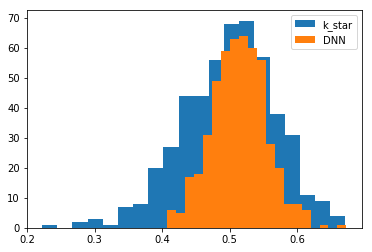

In [57]:
print("k_star - Fréchet - MSE:", np.mean(np.power((gamma_hatF-test_labelsF),2)),", MAE:", np.mean(np.abs((gamma_hatF-test_labelsF))))
evF=modelH.evaluate(test_dataFl, test_labelsF)
print("DNN - Fréchet - MSE:", evF[0], ", MAE:", evF[1])

plt.hist(gamma_hatF, bins=20, label="k_star")
plt.hist(modelH.predict(test_dataFl), bins=20, label="DNN")
legend = plt.legend()
plt.show()

k_star - Cauchy - MSE: 0.0327476747584 , MAE: 0.141871856572
500/500 [==============================] - 0s 65us/step
DNN - Cauchy - MSE: 0.0132289161235 , MAE: 0.0998262720704


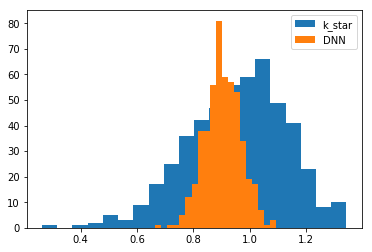

In [58]:
print("k_star - Cauchy - MSE:", np.mean(np.power((gamma_hatC-test_labelsC),2)),", MAE:", np.mean(np.abs((gamma_hatC-test_labelsC))))
evC=modelH.evaluate(test_dataCl, test_labelsC)
print("DNN - Cauchy - MSE:", evC[0], ", MAE:", evC[1])

plt.hist(gamma_hatC, bins=20, label="k_star")
plt.hist(modelH.predict(test_dataCl), bins=20, label="DNN")
legend = plt.legend()
plt.show()

## Considering different sample sizes

A major drawback of such a network is that the architecture determines the number of observations, which can be processed. Thus, you would either train and possibly model an new network for each sample sizes your are confronted with or you rather consider drawing from you data with replacement to obtain samples of the same size. The second approach makes sense, if you have a various samples which do not very drastically. <br>

To evaluate this idea the test data gereated in the following has different sample sizes, but in constrast to the k_star method the DNN is applied to resampled versions of size N.

In [59]:
M=500
dif=200 # sample sizes cosidered range from N-dif to N+dif

## Fréchet(2)
test_dataFlv=np.zeros((M,N))
test_dataFv=np.zeros((M,N+dif))
test_labelsFv=np.zeros(M)
    
for i in range(M):
    gamma=1/2
    Nr=np.random.randint(N-dif,N+dif)
    Xr=stat.invweibull.rvs(c=1/gamma, size=Nr)
    if Nr>=N:
        X=np.asarray(random.sample(list(Xr),N))
    else:
        X=np.zeros(N)
        for j in range(N):
            X[j]=random.choice(Xr)
    test_dataFlv[i,]=np.log(X)
    test_dataFv[i,:len(Xr)]=Xr
    test_labelsFv[i]=gamma
    
    
## Cauchy
test_dataClv=np.zeros((M,N))
test_dataCv=np.zeros((M,N+dif))
test_labelsCv=np.zeros(M)

for i in range(M):
    Nr=np.random.randint(N-dif,N+dif)
    Xr=np.random.standard_cauchy(size=Nr)
    if Nr>=N:
        X=np.asarray(random.sample(list(Xr),N))
    else:
        X=np.zeros(N)
        for j in range(N):
            X[j]=random.choice(Xr)
    test_dataClv[i,]=np.log(abs(X))
    test_dataCv[i,:len(Xr)]=Xr
    test_labelsCv[i]=1

In [60]:
gamma_hatFv=np.zeros(500)

for i in range(500):
    X=test_dataFv[i,][test_dataFv[i,]>0]
    k1=k_star(X)
    gamma_hatFv[i]=hill(X,k1)
    
    
gamma_hatCv=np.zeros(500)

for i in range(500):
    X=test_dataCv[i,][test_dataCv[i,]>0]
    k1=k_star(X)
    gamma_hatCv[i]=hill(X,k1)

k_star - Fréchet - MSE: 0.00606190239339 , MAE: 0.0607154956765
500/500 [==============================] - 0s 86us/step
DNN - Fréchet - MSE: 0.00235977315716 , MAE: 0.0381741177142


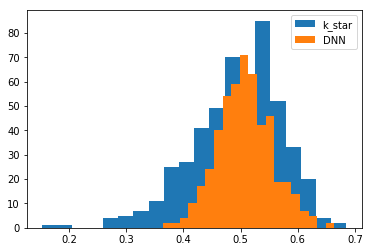

In [61]:
print("k_star - Fréchet - MSE:", np.mean(np.power((gamma_hatFv-test_labelsFv),2)),", MAE:", np.mean(np.abs((gamma_hatFv-test_labelsFv))))
evF=modelH.evaluate(test_dataFlv, test_labelsFv)
print("DNN - Fréchet - MSE:", evF[0], ", MAE:", evF[1])

plt.hist(gamma_hatFv, bins=20, label="k_star")
plt.hist(modelH.predict(test_dataFlv), bins=20, label="DNN")
legend = plt.legend()
plt.show()

k_star - Cauchy - MSE: 0.0367147298227 , MAE: 0.145202995171
500/500 [==============================] - 0s 126us/step
DNN - Cauchy - MSE: 0.0169743040651 , MAE: 0.111550702095


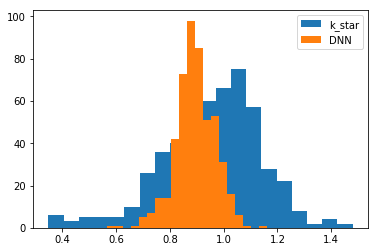

In [62]:
print("k_star - Cauchy - MSE:", np.mean(np.power((gamma_hatCv-test_labelsCv),2)),", MAE:", np.mean(np.abs((gamma_hatCv-test_labelsCv))))
evC=modelH.evaluate(test_dataClv, test_labelsCv)
print("DNN - Cauchy - MSE:", evC[0], ", MAE:", evC[1])

plt.hist(gamma_hatCv, bins=20, label="k_star")
plt.hist(modelH.predict(test_dataClv), bins=20, label="DNN")
legend = plt.legend()
plt.show()

Surprisingly the DNN does not suffer much from the resampling scheme and still peforms better than k_star. It is also remarkable that the DNN leads to a negative bias when estimating $\gamma$ for the Cauchy distribution. This could be an interesting starting point for a deeper analysis on how the network functions.

## Conclusion

Training neural networks in order to learn the extreme value index without the necessary selection of a threshold or sample fraction seems worth further investigation. It would be very interesenting to get insight on the structure of the network and understand how it actually performs this estimation, since we could possibly learn about hidden structures in the data exploited by the network.